In [1]:
%matplotlib inline

In [2]:
import numpy as np
import nibabel as nb
import scipy.stats as stats
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiMasker
import seaborn as sns
from nilearn.input_data import NiftiMasker

### Load gradients and cell data

In [3]:
img = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz')
mask = img.get_data()
aff = img.affine
hdr = img.header

In [4]:
x = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/x2vol_200.npy')
y = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/y2vol_200.npy')
z = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/z2vol_200.npy')
types = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/types.npy')

Types probably:
0 - excitatory neurons;
1 - inhibitory neurons;
2 - oligodendrocytes;
3 - astrocytes;
4 - microglia;

### Make a cell density map

In [14]:
excitatory = np.zeros_like(mask)
inhibitory = np.zeros_like(mask)
for c in range(len(x)):
    if types[c] == 0:
        voxel = (int(np.floor(x[c])), int(np.floor(y[c])), int(np.floor(z[c])))
        if not mask[voxel] == 0:
            excitatory[voxel] +=  1
    elif types[c] == 1:
        voxel = (int(np.floor(x[c])), int(np.floor(y[c])), int(np.floor(z[c])))
        if not mask[voxel] == 0:
            inhibitory[voxel] +=  1
    else:
        pass

In [15]:
nb.save(nb.Nifti1Image(excitatory, aff, hdr), 
        '/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_exc_200um.nii.gz')
nb.save(nb.Nifti1Image(inhibitory, aff, hdr), 
        '/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_inh_200um.nii.gz')

In [5]:
glia = np.zeros_like(mask)
for c in range(len(x)):
    if types[c] in [2,3,4]:
        voxel = (int(np.floor(x[c])), int(np.floor(y[c])), int(np.floor(z[c])))
        if not mask[voxel] == 0:
            glia[voxel] +=  1
    else:
        pass

In [6]:
nb.save(nb.Nifti1Image(glia, aff, hdr), 
        '/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_glia_200um.nii.gz')

### Smooth cell density map with same kernel as gradient

In [8]:
masker = NiftiMasker(mask_img=img, standardize=True, smoothing_fwhm=0.45)
smoothed_trans = masker.fit_transform('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_exc_200um.nii.gz')
smoothed = masker.inverse_transform(smoothed_trans)
smoothed.to_filename('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_exc_200um_smooth045.nii.gz')
excitatory = smoothed.get_data().squeeze()

In [17]:
masker = NiftiMasker(mask_img=img, standardize=True, smoothing_fwhm=0.45)
smoothed_trans = masker.fit_transform('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_inh_200um.nii.gz')
smoothed = masker.inverse_transform(smoothed_trans)
smoothed.to_filename('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_inh_200um_smooth045.nii.gz')
inhibitory = smoothed.get_data().squeeze()

In [9]:
masker = NiftiMasker(mask_img=img, standardize=True, smoothing_fwhm=0.45)
smoothed_trans = masker.fit_transform('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_glia_200um.nii.gz')
smoothed = masker.inverse_transform(smoothed_trans)
smoothed.to_filename('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_glia_200um_smooth045.nii.gz')
glia = smoothed.get_data().squeeze()

### Calcluate Spearman correlation to gradients

In [18]:
gradients = nb.load('/home/julia/data/gradients/results/embedding_vol/embed.nii.gz').get_data()
for g in range(6):
    gradient =  gradients[:,:,:,g]
    print('Gradient %i exc:' %g, stats.spearmanr(excitatory[mask==1], gradient[mask==1]))

Gradient 0 exc: SpearmanrResult(correlation=0.3114471528258974, pvalue=0.0)
Gradient 1 exc: SpearmanrResult(correlation=-0.1965293509425575, pvalue=4.1847561951642523e-134)
Gradient 2 exc: SpearmanrResult(correlation=-0.07435206005633635, pvalue=2.3417328719156384e-20)
Gradient 3 exc: SpearmanrResult(correlation=0.17895723384848441, pvalue=3.667993395027023e-111)
Gradient 4 exc: SpearmanrResult(correlation=-0.2953323588858909, pvalue=5.696749633205808e-308)
Gradient 5 exc: SpearmanrResult(correlation=0.008658072367945274, pvalue=0.28231263326117545)


In [19]:
gradients = nb.load('/home/julia/data/gradients/results/embedding_vol/embed.nii.gz').get_data()
for g in range(6):
    gradient =  gradients[:,:,:,g]
    print('Gradient %i inh:' %g, stats.spearmanr(inhibitory[mask==1], gradient[mask==1]))

Gradient 0 inh: SpearmanrResult(correlation=0.1614040869634561, pvalue=1.6300281685082797e-90)
Gradient 1 inh: SpearmanrResult(correlation=0.12179081183178182, pvalue=4.801848551131764e-52)
Gradient 2 inh: SpearmanrResult(correlation=0.07576111144305489, pvalue=4.4596691988573404e-21)
Gradient 3 inh: SpearmanrResult(correlation=0.022954738440310596, pvalue=0.004361122061692134)
Gradient 4 inh: SpearmanrResult(correlation=-0.037466124247119356, pvalue=3.2555626306526494e-06)
Gradient 5 inh: SpearmanrResult(correlation=0.08829988616236097, pvalue=4.456443382486371e-28)


In [10]:
gradients = nb.load('/home/julia/data/gradients/results/embedding_vol/embed.nii.gz').get_data()
for g in range(6):
    gradient =  gradients[:,:,:,g]
    print('Gradient %i glia:' %g, stats.spearmanr(glia[mask==1], gradient[mask==1]))

Gradient 0 glia: SpearmanrResult(correlation=0.2125779927292925, pvalue=4.381531240169616e-157)
Gradient 1 glia: SpearmanrResult(correlation=-0.03914708006980459, pvalue=1.1564114078845693e-06)
Gradient 2 glia: SpearmanrResult(correlation=0.4060914724998571, pvalue=0.0)
Gradient 3 glia: SpearmanrResult(correlation=-0.1137690835240265, pvalue=1.3396396173075261e-45)
Gradient 4 glia: SpearmanrResult(correlation=-0.2548282918898876, pvalue=3.8258185146053146e-227)
Gradient 5 glia: SpearmanrResult(correlation=0.12252537717271719, pvalue=1.1716268865795265e-52)


### Plot

In [20]:
template = nb.load('/home/julia/data/gradients/atlas/allen_api/template_200.nii.gz').get_data()

In [21]:
excitatory[mask==0] = np.nan
inhibitory[mask==0] = np.nan
gradient_0 = gradients[:,:,:,0]
gradient_0[mask==0] = np.nan
gradient_4 = gradients[:,:,:,4]
gradient_4[mask==0] = np.nan

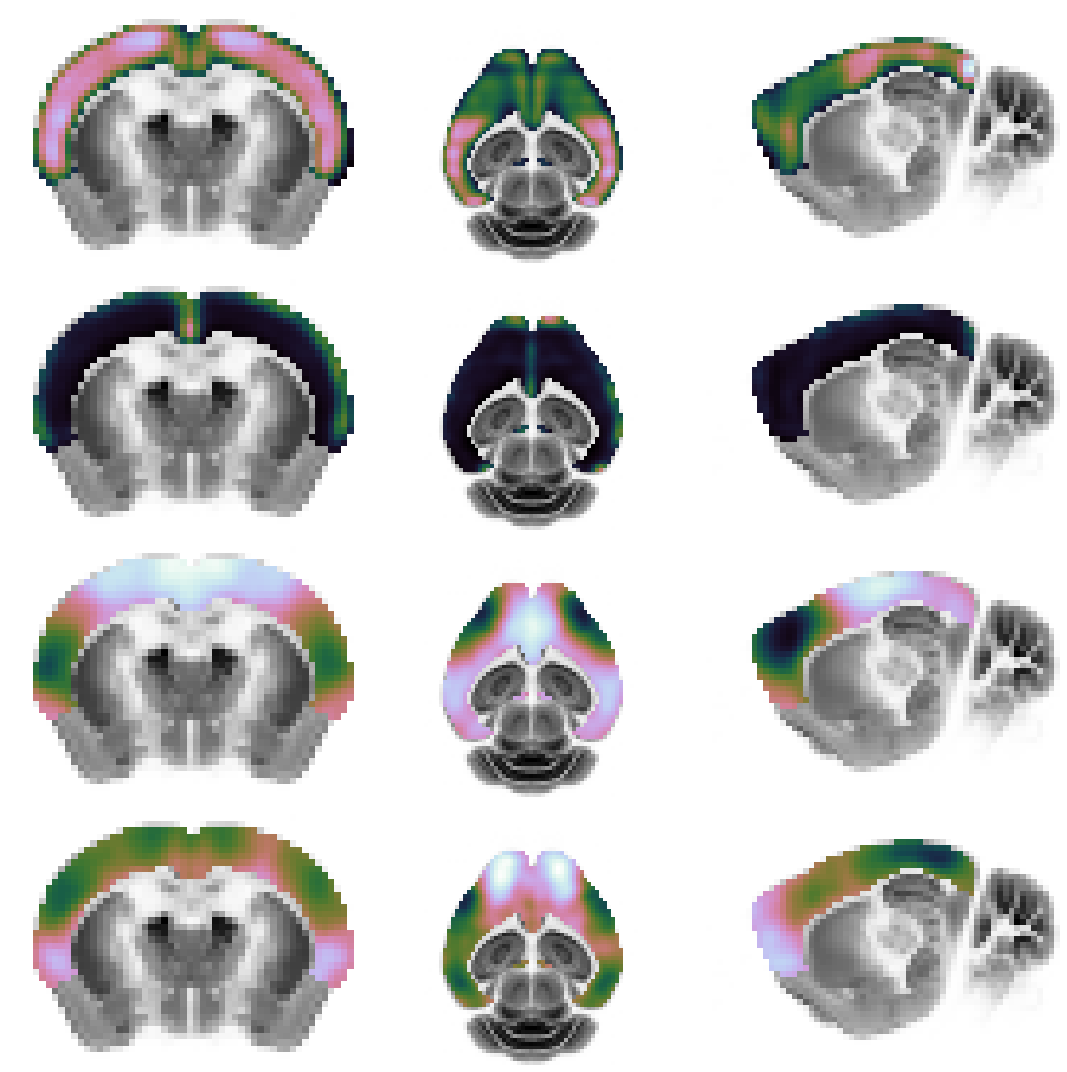

In [26]:
x=30
y=10
z=15


fig = plt.figure(figsize=(15,15))

vmin = np.nanmin(excitatory)
vmax = np.nanmax(excitatory)

fig.add_subplot(4,3,1)
plt.imshow(template[x,:,:],  cmap='Greys', aspect='equal');
plt.imshow(excitatory[x,:,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(4,3,2)
plt.imshow(template[:,y,:],  cmap='Greys', aspect='equal');
plt.imshow(excitatory[:,y,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(4,3,3)
plt.imshow(template[:,:,z].T,  cmap='Greys', aspect='equal');
plt.imshow(excitatory[:,:,z].T,  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

vmin = np.nanmin(inhibitory)
vmax = np.nanmax(inhibitory)


fig.add_subplot(4,3,4)
plt.imshow(template[x,:,:],  cmap='Greys', aspect='equal');
plt.imshow(inhibitory[x,:,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(4,3,5)
plt.imshow(template[:,y,:],  cmap='Greys', aspect='equal');
plt.imshow(inhibitory[:,y,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(4,3,6)
plt.imshow(template[:,:,z].T,  cmap='Greys', aspect='equal');
plt.imshow(inhibitory[:,:,z].T,  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');


vmin = np.nanmin(gradient_0)
vmax = np.nanmax(gradient_0)

fig.add_subplot(4,3,7)
plt.imshow(template[x,:,:],  cmap='Greys', aspect='equal');
plt.imshow(gradient_0[x,:,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(4,3,8)
plt.imshow(template[:,y,:],  cmap='Greys', aspect='equal');
plt.imshow(gradient_0[:,y,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(4,3,9)
plt.imshow(template[:,:,z].T,  cmap='Greys', aspect='equal');
plt.imshow(gradient_0[:,:,z].T,  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

vmin = np.nanmin(gradient_4)
vmax = np.nanmax(gradient_4)

fig.add_subplot(4,3,10)
plt.imshow(template[x,:,:],  cmap='Greys', aspect='equal');
plt.imshow(gradient_4[x,:,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(4,3,11)
plt.imshow(template[:,y,:],  cmap='Greys', aspect='equal');
plt.imshow(gradient_4[:,y,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(4,3,12)
plt.imshow(template[:,:,z].T,  cmap='Greys', aspect='equal');
plt.imshow(gradient_4[:,:,z].T,  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

plt.tight_layout()